In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from agent import Agent, Env
from pfilter import ParticleFilter
from scipy.special import logsumexp

In [2]:
im_x = 40
im_y = 40

seqlen = 40

n_agents = 4

In [3]:
env = Env(*[Agent(im_x, im_y) for _ in range(n_agents)])

In [4]:
# env.agents[0].dim = env.agents[1].dim
# env.agents[0].pos = env.agents[1].pos
# env.agents[0].vel = env.agents[1].vel

In [5]:
aa = env.step()

In [6]:
aa

[array([ 29.38660085,  14.02954066,  38.44818937,  22.3501104 ]),
 array([ 30.74497668,   7.98218346,  36.73238143,  11.9819488 ]),
 array([ -0.36790454,  31.84297383,   9.66740589,  37.34261337]),
 array([ 17.69344059,  29.80889262,  25.70025397,  34.86283666])]

In [7]:
def all_permutations(l):
    if l == 0:
        return [[0]]
    else:
        prev = all_permutations(l-1)
        ans = []
        for i in range(l+1):
            for perm in prev:
                tmp = perm[:]
                tmp.insert(i, l)
                ans.append(tmp)
        return ans

In [8]:
def evol_model(particles):
    particles = particles.copy()
    
    xy, wh = particles[:,:2], particles[:,2:4]
    vel = particles[:,4:]
    
    vel += np.random.normal(size=vel.shape)/12
    vel = np.clip(vel, -1, 1)
    
    xy += vel
    
    wh += np.random.normal(size=wh.shape)/20
    wh = np.clip(wh, 1, 30)
    
    xy = np.clip(xy, 0, np.array([im_x, im_y], dtype='float64') - wh)
    
    new_particles = np.concatenate([xy, wh, vel], axis=-1)
    return new_particles

def observe_model(particles, observe, beta=None):
    xy, wh = particles[:,:2], particles[:,2:4]
    
    xyxy = np.concatenate([xy, xy + wh], axis=-1)
    
    whs = np.stack([wh,wh], axis=-1).reshape((-1,4))
    
    ds = []
    for obs in observe:
        logd = - (xyxy - obs)**2/(2*(whs/8)**2) - np.log(np.sqrt(2*np.pi)*whs)
        logd = np.clip(logd, -10000, 10000)
        logd = np.sum(logd, axis=-1)
        ds.append(logd)
    
    
    ds = np.array(ds)
    #print(ds.shape)
    if beta is not None:
        beta = np.array(beta)
        
        #return np.log(np.exp(ds)*beta[:,np.newaxis].sum(axis=0))
        return logsumexp(ds, b=beta[:,np.newaxis], axis=0)
    else:
        return ds

In [9]:
filters = []
aa_ = env.step()
for i in range(n_agents):
    filt = ParticleFilter(50, 4 + 2, evol_model, observe_model, resample_2entropy=0.8)
    aa = aa_[i]
    filt.particles[:, :2] = aa[:2] + np.random.normal(size=filt.particles[:, :2].shape)*1
    filt.particles[:, 2:4] = np.clip(aa[2:4] - aa[:2] + np.random.normal(size=filt.particles[:, 2:4].shape)*3, 1, 100)
    filters.append(filt)

In [10]:
observe = []
true = []
for _ in range(seqlen):
    observe.append(env.step())
    true.append([agent.pos for agent in env.agents])
    
observe = np.array(observe)
true = np.array(true)

In [11]:
agent = env.agents[1]

In [12]:
agent.w, agent.h

(6, 4)

In [13]:
filtrated = [[]]

for obs in observe:
    betamat = np.zeros([len(filters), len(obs)], dtype='float64')

    for j, oo in enumerate(obs):
        for i, filt in enumerate(filters):
            ds = observe_model(filt.particles, [oo])[0] + filt.logweights
            #print('logweights {} {}: {}'.format(i, j, ds))
            betamat[i, j] = np.mean(np.exp(ds))
    
    #print(betamat)
              
    betaij = np.zeros_like(betamat)
    for perm in all_permutations(len(filters) - 1):
        for k, j in enumerate(perm):
            betaij[k,j] += np.prod(np.diag(betamat[:,perm]))
            
    betaij /= np.sum(betaij)
    #print(betaij)
            
    for i, filt in enumerate(filters):
        part, w = filt.step(obs, betaij[i,:])
        ix = np.random.choice(np.arange(len(part)), size=len(part), p=w)
        filtrated[-1].append(part[ix])
        #print('after update {}'.format(filt.logweights))
    filtrated.append([])

In [14]:
betaij

array([[  1.25000000e-001,   1.58097107e-072,   0.00000000e+000,
          2.18206105e-089,   0.00000000e+000,   1.07291860e-081,
          0.00000000e+000,   0.00000000e+000],
       [  1.58097107e-072,   1.25000000e-001,   0.00000000e+000,
          4.04250131e-013,   0.00000000e+000,   1.67711975e-013,
          0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000,   1.25000000e-001,
          0.00000000e+000,   1.57500455e-151,   0.00000000e+000,
          3.06536299e-226,   0.00000000e+000],
       [  4.99393846e-104,   4.04489923e-013,   0.00000000e+000,
          1.24999996e-001,   0.00000000e+000,   4.28429442e-009,
          0.00000000e+000,   0.00000000e+000],
       [  0.00000000e+000,   0.00000000e+000,   1.57500455e-151,
          0.00000000e+000,   1.25000000e-001,   0.00000000e+000,
          0.00000000e+000,   0.00000000e+000],
       [  1.60367682e-100,   1.67472184e-013,   0.00000000e+000,
          4.28429466e-009,   0.00000000e+000,   1.

In [15]:
filtrated = np.array(filtrated[:-1])

In [16]:
filtrated.shape

(40, 8, 50, 6)

In [17]:
filtrated = filtrated.transpose([0,2,1,3])

In [18]:
fmean = filtrated.mean(axis=1)

In [19]:
fmean.shape

(40, 8, 6)

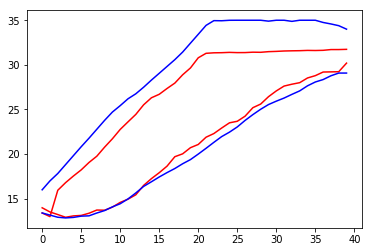

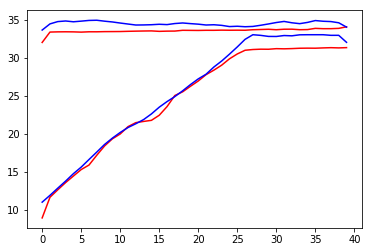

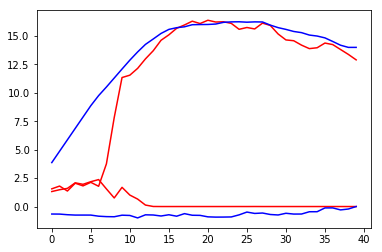

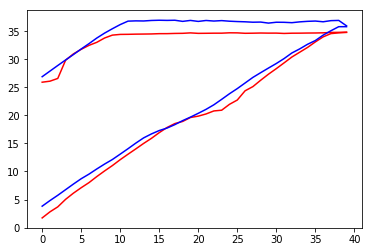

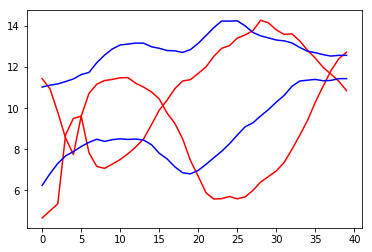

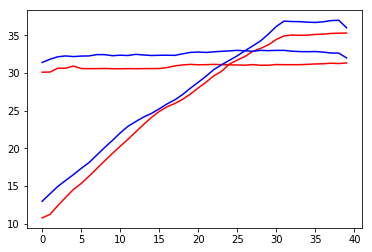

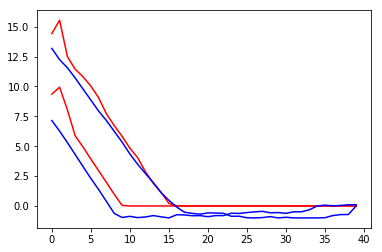

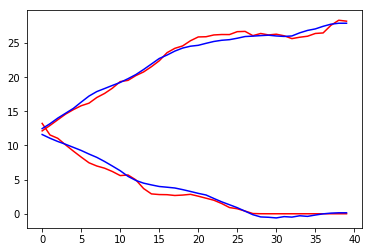




Object Dims:


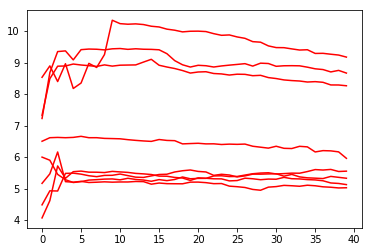

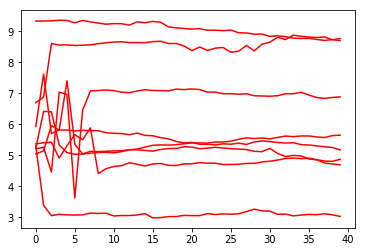

In [20]:
for i in range(n_agents):
    plt.plot(range(seqlen), fmean[:,i,:2], c='r')
    plt.plot(range(seqlen), true[:,i], c='b')
    plt.show()

print('\n\n\nObject Dims:')
plt.plot(range(seqlen), fmean[:,:,2], c='r')
plt.show()

plt.plot(range(seqlen), fmean[:,:,3], c='r')
plt.show()